<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
pip install sklearn-lvq

In [110]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn_lvq import GlvqModel
from sklearn_lvq.utils import plot2d
from sklearn.mixture import GaussianMixture
from statsmodels.graphics.tsaplots import plot_acf
import pandas as pd
import statsmodels.api as sm
from sklearn_lvq import GlvqModel
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import math
from math import sqrt

In [111]:
#Para acomodar la información si viene por minuto y en registros, 
#df = pd.read_csv('rg1.csv')
## aqui agrupamos por minuto
#df_grouped_multiple = df.groupby(['YEAR','MONTH','DAY','HOUR']).agg({'RG1': ['mean']})
#df_grouped_multiple.columns = ['rg1_mean']
#df_grouped_multiple = df_grouped_multiple.reset_index()
## aquí pivoteamos
#df1 = df_grouped_multiple.pivot(index=['YEAR','MONTH','DAY'], columns='HOUR', values='rg1_mean').dropna()
#print(df1) #df1.to_csv('res.csv')
#df1.columns = [['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17', '18','19', '20', '21', '22', '23']]

In [112]:
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-";
def print_serie(serie_,title_,dot_,namefile_):
    fig, ax1 = plt.subplots(figsize=(7,4))
    plt.title(title_,fontsize='x-large',color=LETRASNARA)
    ax1.set_xlabel('horas', color=LETRASNARA, fontsize='large')
    ax1.set_ylabel('radiación solar', color=LETRASNARA, fontsize='large')
    plt.tick_params(colors = LETRASNARA, which='both')
    ax1.spines['bottom'].set_color(LETRASNARA)
    ax1.spines['top'   ].set_color(LETRASNARA) 
    ax1.spines['right' ].set_color(LETRASNARA)
    ax1.spines['left'  ].set_color(LETRASNARA)    
    for p in serie_:
        if dot_== True:
           plt.plot(p,alpha=0.4, linestyle='dashed', linewidth=3)
        else:
           plt.plot(p,alpha=0.4)                
    plt.savefig(namefile_, transparent=True)         
    plt.show()

In [113]:
def scatterplot(X_,Y_,tags_,centers_,title_,namefile_ ):
    fig, ax1 = plt.subplots(figsize=(4,4))
    CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-";
    for k in centers_:
        x = k[7]; y = k[8]
        plt.plot(x,y,"o",color="red",)
    plt.title(title_,fontsize='x-large',color=LETRASNARA)
    ax1.set_xlabel('hora 7',  color=LETRASNARA, fontsize='large')
    ax1.set_ylabel('hora 8',  color=LETRASNARA, fontsize='large')
    plt.scatter(X_, Y_, c=tags_, alpha=0.3)
    plt.tick_params(colors = LETRASNARA, which='both')
    ax1.spines['bottom'].set_color(LETRASNARA)
    ax1.spines['top'   ].set_color(LETRASNARA) 
    ax1.spines['right' ].set_color(LETRASNARA)
    ax1.spines['left'  ].set_color(LETRASNARA)
    plt.savefig(namefile_, transparent=True)
    plt.show()

In [114]:
def print_patrones(list_series,list_categorias,list_patrones,title_,namefile_): 
    cat = np.unique(list_categorias)
    n = math.ceil(pow(n_clusters, 0.5))
    fig, axs = plt.subplots(n, n, figsize=(15,14))
    row=0; col=0
    for c in cat:
        j = 0
        for g in list_categorias:    
            if c == g:
                axs[row,col].plot(list_series[j],alpha=0.5)
                axs[row,col].set_title(title_+str(c))
                #axs[row,col].xaxis.set_xlabel(horas_invierno)
            j = j + 1
        if len(list_patrones) != 0:
            axs[row, col].plot(list_patrones[c],alpha=0.7,color='red',linestyle='dashed',linewidth=4)
        col = col + 1
        if col == n:
            col = 0
            row = row + 1  
    plt.savefig(namefile_, transparent=True)
    plt.show()

# **Leemos datos**

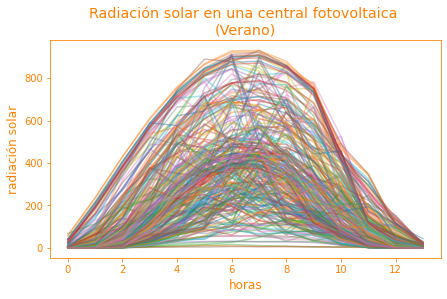

In [115]:
df = pd.read_csv('rg1_horas.csv')
df_invierno = df[(df.MONTH==11)|(df.MONTH==12)|(df.MONTH==1)|(df.MONTH==2)|(df.MONTH==3)|(df.MONTH==4)]
df_verano   = df[(df.MONTH==5) |(df.MONTH==6) |(df.MONTH==7)|(df.MONTH==8)|(df.MONTH==9)|(df.MONTH==10)]
df = df_invierno
horas_verano   = ['4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19']
horas_invierno = ['5','6','7','8','9','10','11','12','13','14','15','16','17','18']
X = df[horas_invierno].to_numpy()
x_total   = df[['SUMA']].to_numpy()
dx_total  = df[['dSUMA']].to_numpy()
ddx_total = df[['ddSUMA']].to_numpy()

#Normalizing the data
#sc = StandardScaler()
#X  = sc.fit_transform(X)
#y  = sc.fit_transform(Y)

## Crea conjuntos de datos de entrenamiento y prueba
X_train, X_test = train_test_split(X, test_size=0.2)

print_serie(X_train,'Radiación solar en una central fotovoltaica \n(Verano)',False,'fig_t13_all')
#print_serie(X_test,'X_test',False)

# **Weighted KNN**


In [116]:
#https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/
def euclidean_distance(row1, row2):
	  distance = 0.0
	  for i in range(len(row1)-1):
		    distance += (row1[i] - row2[i])**2
	  return sqrt(distance)
   
dataset = [[2.7810836,2.550537003,0],
	[1.465489372,2.362125076,0],
	[3.396561688,4.400293529,0],
	[1.38807019,1.850220317,0],
	[3.06407232,3.005305973,0],
	[7.627531214,2.759262235,1],
	[5.332441248,2.088626775,1],
	[6.922596716,1.77106367,1],
	[8.675418651,-0.242068655,1],
	[7.673756466,3.508563011,1]]

row0 = dataset[0]
for row in dataset:
	  distance = euclidean_distance(row0, row)
	  print(distance)

0.0
1.3290173915275787
1.9494646655653247
1.5591439385540549
0.5356280721938492
4.850940186986411
2.592833759950511
4.214227042632867
6.522409988228337
4.985585382449795


In [117]:
# Locate the most similar neighbors
def get_neighbors(train, test_row, num_neighbors):
  
    distances = list()

    for train_row in train:
        dist = euclidean_distance(test_row, train_row)
        distances.append((train_row, dist))
    distances.sort(key=lambda tup: tup[1])

    neighbors = list()

    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
    return neighbors

In [118]:
neighbors = get_neighbors(dataset, dataset[0], 3)
for neighbor in neighbors:
	  print(neighbor)

[2.7810836, 2.550537003, 0]
[3.06407232, 3.005305973, 0]
[1.465489372, 2.362125076, 0]


In [119]:
# Make a classification prediction with neighbors
def predict_classification(train, test_row, num_neighbors):
	neighbors = get_neighbors(train, test_row, num_neighbors)
	output_values = [row[-1] for row in neighbors]
	prediction = max(set(output_values), key=output_values.count)
	return prediction

In [120]:
prediction = predict_classification(dataset, dataset[0], 3)
print('Expected %d, Got %d.' % (dataset[0][-1], prediction))

Expected 0, Got 0.


# **K-means**


y_kmeans [14 14  5 10 10 14 11  0  4  5  3  5 14 10 10 10  5 12  9  5 14 14 14  5
 10 13  4  5  0  5  4 10  5 10  2  5  2 15  6  9  4  4 14  9 12  4 15 14
  1  1  9 14 14  0 13  6  5  4  7  0 10  4  6  5  0  8 11  4 10 10  5  5]
y_kmeans_train [ 8 13  3  6  6  5  2 14  8 11 14 13  5 10  0 14  1 11  5  4  2  3 11 14
 15 10  2 11  8 14 10 10  2 11  2 15  8  5 13 14  4  1  2  1 13  0  7  4
 14  3 10  2  2 13  5 14  7  8 11  3  4  6 14 14  8  8 10 11 13  9  0 10
 14 12 10  2  5 15  3 13 14  4 10 12 11 11  8  0 15  4 10  0  5 10 13 14
  7 13 10  0  1  3  5  8 10  4  8  2  0  4 14  0  6 14  1  3  1 10  8 12
 14  8  4  8 14 15  9 13  4  9 14 10  1 10 13 14 11  7  3 15  4  0 10 10
  1 10  2  5 15 14  2  1  9  4 14  3  7 11 11 14 14  5  5 10 14  2  4  5
 14 11 10  9  0  2  9  4 11 10  4 11  2 15 10  5 13 15  0  8  9  0 11 10
  0 13  4 15 11 11  1  1 10  9 14  4 10  5  0 10 14  7  4  6 13  7  5  4
  7  5  5 10  5  1  4  9 12 11 11  4  4  5  3  7 11  5  8 11  4  3  1 14
 14  3 14  7 10  4  0 14  

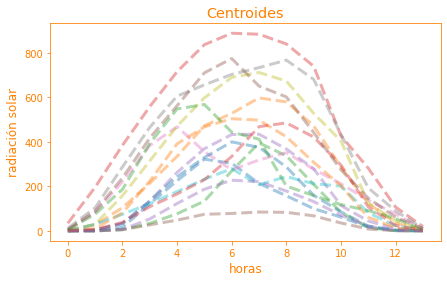

In [121]:
n_clusters = 16
k_means = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10) # una variante MiniBatchKMeans  
k_means = k_means.fit(X_train)
values  = k_means.cluster_centers_.squeeze()
labels  = k_means.labels_
centers_= k_means.cluster_centers_
#print('Centroides', centers_)
#print('Exactitud:', k_means.score(X_test))
y_kmeans = k_means.predict(X_test)
y_kmeans_train = k_means.predict(X_train)
print('y_kmeans' , y_kmeans)
print('y_kmeans_train' , y_kmeans_train)
print_serie(centers_,'Centroides',True,'fig_t13_centroids')
#scatterplot(X_train[:,4],X_train[:,8],labels,centers_,'Radiación solar \n K-means \n(entrenamiento)','fig_t13_train')

X_train (kmeans)


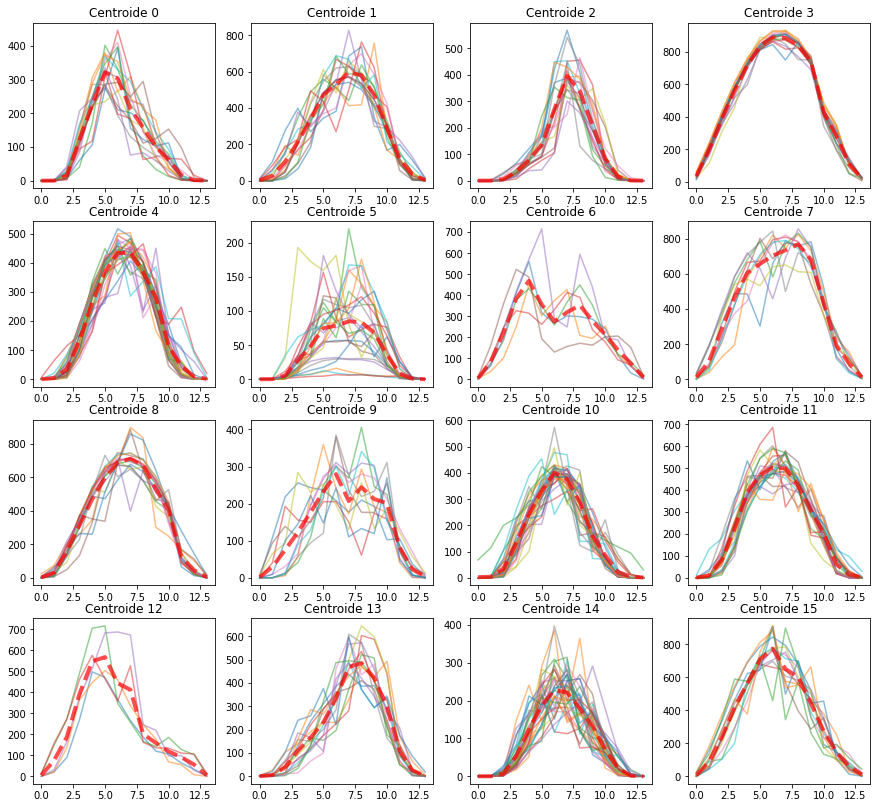

In [122]:
print('X_train (kmeans)')
print_patrones(list_series=X_train,list_categorias=y_kmeans_train,list_patrones=centers_,title_='Centroide ',namefile_='fig_t13_kmeans_train')

X_test (kmeans)


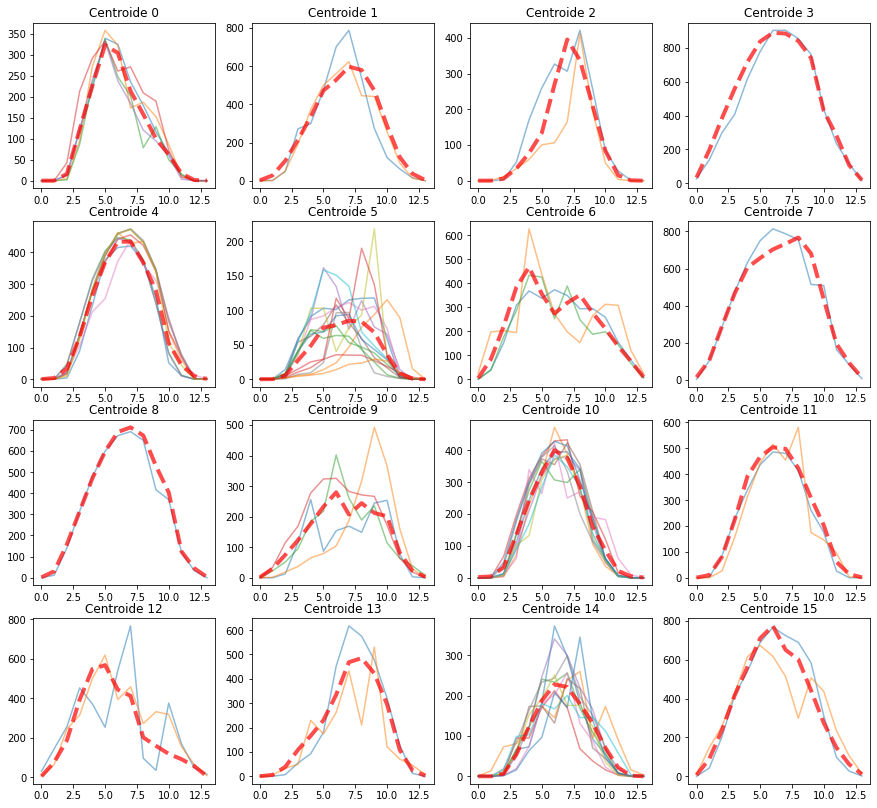

In [123]:
print('X_test (kmeans)')
print_patrones(list_series=X_test,list_categorias=y_kmeans,list_patrones=centers_,title_='Centroide ',namefile_='fig_t13_kmeans_test')

# **LVQ**

In [124]:
#https://mrnuggelz.github.io/sklearn-lvq/auto_examples/plot_rslvq.html
#https://mrnuggelz.github.io/sklearn-lvq/auto_examples/index.html
#https://mrnuggelz.github.io/sklearn-lvq/modules/generated/sklearn_lvq.GlvqModel.html#sklearn_lvq.GlvqModel
#https://mrnuggelz.github.io/sklearn-lvq/auto_examples/plot_glvq.html#sphx-glr-auto-examples-plot-glvq-py

print('GLVQ')
glvq = GlvqModel(prototypes_per_class=1, initial_prototypes=None)
glvq.fit(X_train,labels)
glvq_pred = glvq.predict(X_test)
glvq_pred_train = glvq.predict(X_train)
print('glvq_pred',glvq_pred)
print('glvq_pred_train', glvq_pred_train)
print('classification accuracy:', (glvq.score(X_test, glvq_pred)))
plt.show()

GLVQ
glvq_pred [14 14  5 10 10 14 11  0  4  5  3  5 14 10 10 10  5 12  9  5 14 14 14  5
 10 13  4  5  0  5  4 10  5 10 10  5 14  8  6  9  4  4 14  9 12  4 15 14
  1  1  9 14 14  0 13  6  5  4  7  0 10  4  6  5  0  8 11  4 10 10  5  5]
glvq_pred_train [ 8 13  3  6  6  5  2 14  8 11 14 13  5 10  0 14  1 11  5  4  2  3 11 14
 15 10  2 11  8 14 10 10  2 11  2 15  8  5 13 14  4  1  2  1 13  0  7  4
 14  3 10  2  2 13  5 14  7  8 11  3  4  6 14 14  8  8 10 11 13  9  0 10
 14 12 10  2  5 15  3 13 14  4 10 12 11 11  8 10 15  4 10  0  5 10 13 14
  7 13 10  0  1  3  5  8 10  4  8  2  0  4 14  0  6 14  1  3  1 10  8 12
 14  8  4  8 14 15  9 13  4  9 14 10  1 10 13 14 11  7  3 15  4  0 10 10
  1 10  2  5 15 14  2  1  9  4 14  3  7 11 11 14 14  5  5 10 14 14  4  5
 14 11 10  9  0  2  9  4 11 10  4 11  2 15 10  5 13 15 14  8  9  0 11 10
  0 13  4 15 11 11  1  1 10  9 14  4 10  5  0 10 14  7  4  6 13  7  5  4
  7  5  5 10  5  1  4  9 12 11 11 10 10  5  3  7 11  5  8 11  4  3  1 14
 14  3 14  7 10  4 

X_train (LVQ)


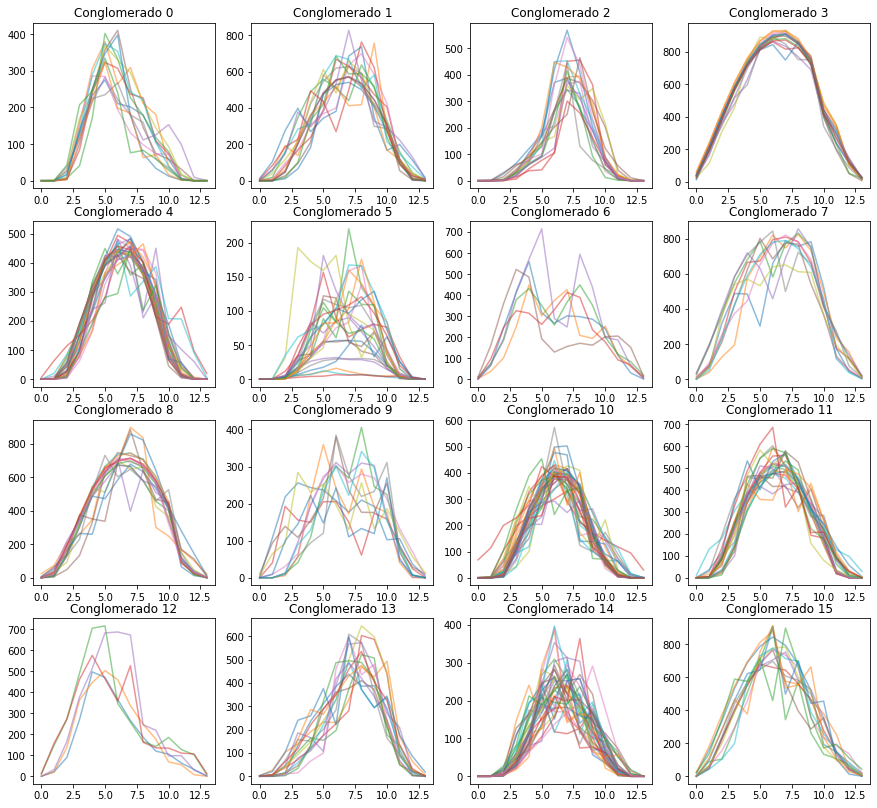

In [125]:
print('X_train (LVQ)')
print_patrones(list_series=X_train,list_categorias=glvq_pred_train,list_patrones=[],title_='Conglomerado ',namefile_='fig_t13_lvq_train')

X_test (LVQ)


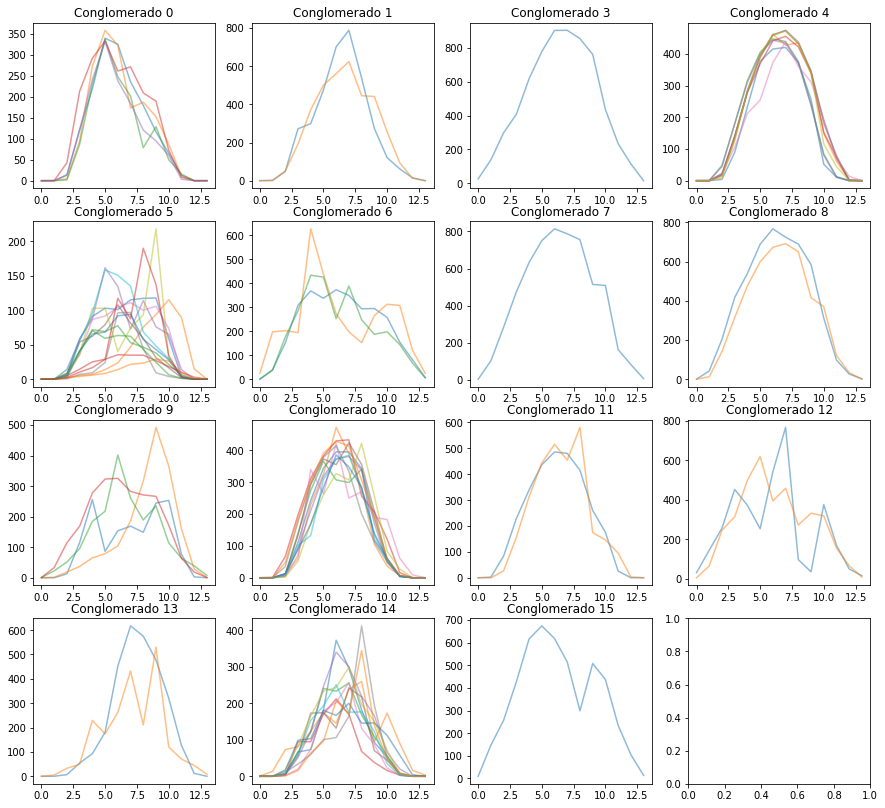

In [126]:
print('X_test (LVQ)')
print_patrones(list_series=X_test,list_categorias=glvq_pred,list_patrones=[],title_='Conglomerado ',namefile_='fig_t13_lvq_test')

# **GaussianMixture**

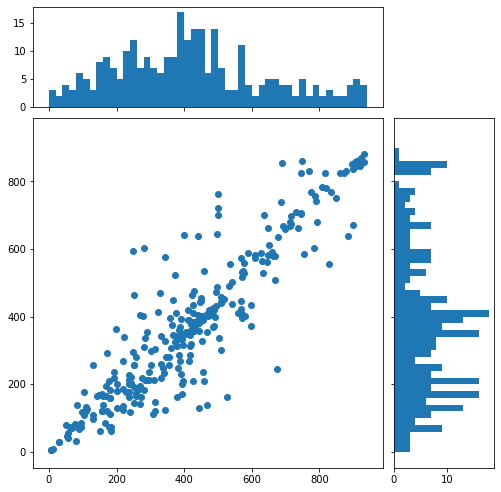

In [127]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    # the scatter plot:
    ax.scatter(x, y)
    # now determine nice limits by hand:
    binwidth = 20
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth
    bins = np.arange(0, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')
# start with a square Figure
fig = plt.figure(figsize=(8, 8))

# Add a gridspec with two rows and two columns and a ratio of 2 to 7 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# use the previously defined function
scatter_hist(X_train[:,7],X_train[:,8], ax, ax_histx, ax_histy)

plt.show()

In [128]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py
#https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
gm = GaussianMixture(n_components=n_clusters, init_params='kmeans',covariance_type='full') #full, tied, diag, spherical
gm.fit(X_train)
gm_pred_train = gm.predict(X_train)
gm_pred       = gm.predict(X_test)

print('classification accuracy train:', gm.score(X_train, gm_pred_train))
print('classification accuracy:', gm.score(X_test, gm_pred))

print('gm_pred',gm_pred)
print('gm_pred_train', gm_pred_train)


classification accuracy train: -36.831922355857486
classification accuracy: -122.73311980102393
gm_pred [ 7 12  7  7  7  7  0  7  7  5  1  7  7  7  0  7  5 12  5  7  7  7  7  7
  7  5  5  7  7  7  0 12  7  7  7  7  7 12 12 12  5  0  7 12 12  5 12  7
 12 12 12  5  7  7 12 12  7 12 12  7  7  5 12  5  7 12  5  7  7  0  7  7]
gm_pred_train [12  5  1  9 15  5  5  7  3  0  2 13  5  7  7  7  4  0  7  0  7  1  0  7
 10  7  7  0 12  7  7  7  7  8  7 10 12  7 13  7  0  6  5 12 13  7 11  0
  7  1  7  7  7 13  7  7 11 12  8  1  0  9  7  7  3 12  7  0 13 14  7  7
  7 15 15  5  7  4  1 13  7  7  7 15  0  0 12  2 12  5  7  7  7  0 13  7
  1 13 15  2  6  1  5 12 15  7 12  7  7  7  7  7 15  7  6  1  6  2 11  9
  7 12  7 12  7 12  2 13  7  5  7  7  6 15 13  7  8 11  1 10  8  7  7  7
  6  7  7  7  3  7  7  6 14  7  2  1  1  0  8  7  2  5  5  7  7  7  0  7
  2  5  7  5  2  7  2  0  0  7  0  0  7 12 15  7  5 12  7 12  5  7  6  7
  7  5  0  3  0  8  4  6  7  5  7  5  7  5  7  7  7 12  7  9 13 11  5  0
 10  

X_train (GaussianMixture)


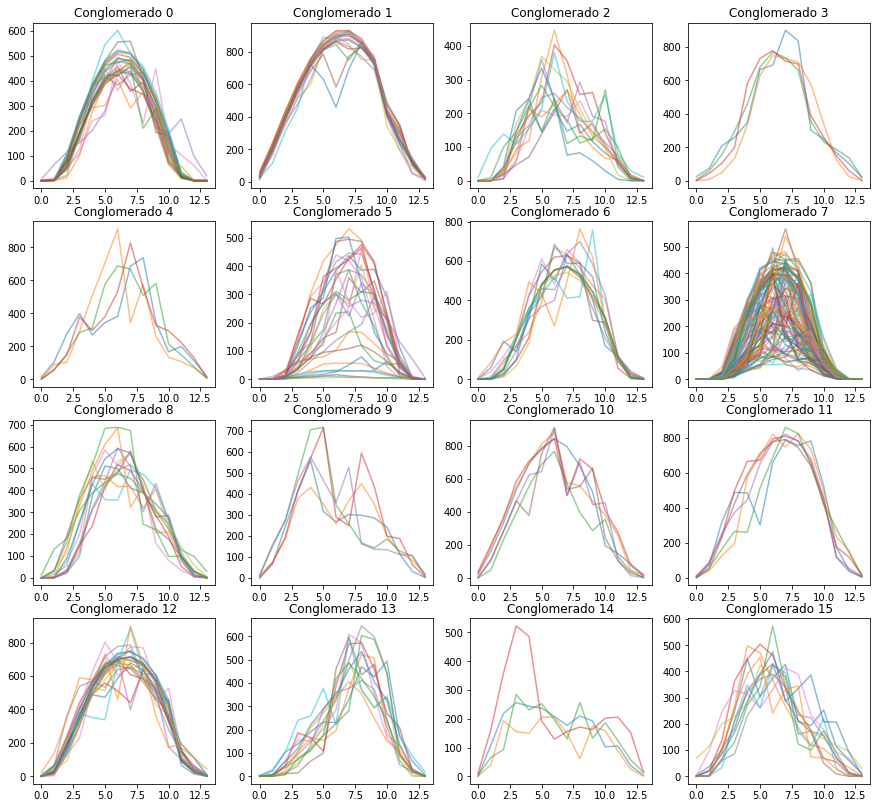

In [129]:
print('X_train (GaussianMixture)')
print_patrones(list_series=X_train,list_categorias=gm_pred_train,list_patrones=[],title_='Conglomerado ',namefile_='fig_t13_gm_train')

X_test (GaussianMixture)


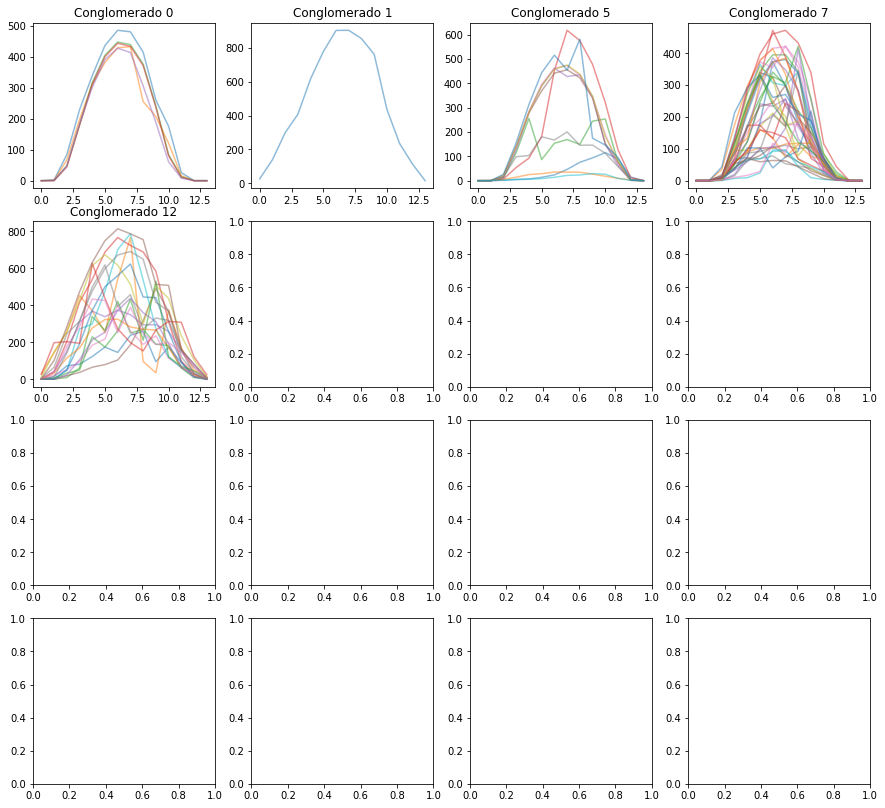

In [130]:
print('X_test (GaussianMixture)')
print_patrones(list_series=X_test,list_categorias=gm_pred,list_patrones=[],title_='Conglomerado ',namefile_='fig_t13_gm_test')

# **KNN**

In [131]:
#https://scikit-learn.org/stable/modules/neighbors.html#classification
nbrs = NearestNeighbors(n_neighbors=10, algorithm='auto').fit(X_train)  #['auto','ball_tree','kd_tree','brute'].
distances, indices = nbrs.kneighbors(X_train)
print(distances, indices)
nbrs.kneighbors_graph(X_train).toarray()

[[  0.         177.03161676 184.77473294 ... 247.30100077 251.28831987
  276.79804962]
 [  0.         143.63818552 173.33744151 ... 220.75077644 222.15383811
  230.34677538]
 [  0.          30.73171989  38.71882618 ... 110.73636861 110.8397166
  115.57692361]
 ...
 [  0.         105.56373005 167.0679519  ... 248.83929946 258.51262114
  268.28075264]
 [  0.          31.55575314  77.69095109 ... 120.52305219 123.1361069
  124.85989367]
 [  0.         389.70751813 443.15968653 ... 570.37147388 582.93280344
  589.23762412]] [[  0 123 234 ... 187  65 151]
 [  1 184 212 ... 266 226  81]
 [  2  49 115 ... 263 241 250]
 ...
 [285 146 107 ...   6  50  34]
 [286 128 109 ...  13  90  89]
 [287   3  69 ...   4 152  73]]


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [132]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, labels)
knn_pred_train = knn.predict(X_train)
knn_pred       = knn.predict(X_test)
print('knn_pred', knn_pred)
print('knn_pred_train',knn_pred_train )
print(knn.score(X_test,knn_pred))

knn_pred [14 14  5 10 10 14 11  0  4  5  3  5 14 10  4 10  5 11 14  5 14 14 14  5
 10 13  4  5  0  5  4 10  5 10 10  5 14  8  6  2  4  4 14  9 11  4 15 14
 11 11 10 14 14  0  4  6  5  4  7  0 10  4  6  5  0  8 11  4 10  4  5  5]
knn_pred_train [ 8 13  3  6 10  5 10 14  8 11 14 13  5 10  0 14  1 11  5  4  2  3 11  5
  3 10  2 11  8 14 10 10  2 11  2 15  8  5 13 14  4  1  2  8 13  0  8  4
 14  3 10  2 14 13  5 14  8  8 11  3  4 11 14 14  8  8 10 11 13  9  0 10
 14 10 10  2  5 15  3 13 14  4 10 10 11 11  8  0  8 10 10  0  5  4 13 14
  3 13 10 14  1  3  5  8 10  4  8  2  0  4 14  0  6 14  1  3  1 10  8 12
 14  8  4  8 14  8  9 13  4  9 14 10  1 10 13 14 11  3  3 15  4  0 10 10
 11 10  2 14  8 14  2  1  9  4 14  3  7 11 11 14 14  5  5 10 14  2  4  5
 14 11 10  9  0  2  9  4 11 10  4 11  2  8 10  5  4 15 14  8  9  0 11 10
  0  4  4  8 11 11  1  1 10  9 14  4 10  5  0 10 14  8  4 11 13  8  5  4
  3  5  5 10  5  1  4  9 12 11 11  4 10  5  3  8 11  5  8 11  4  3  1 14
 14  3 14  8 10  4  0 14  

X_train (KNN)


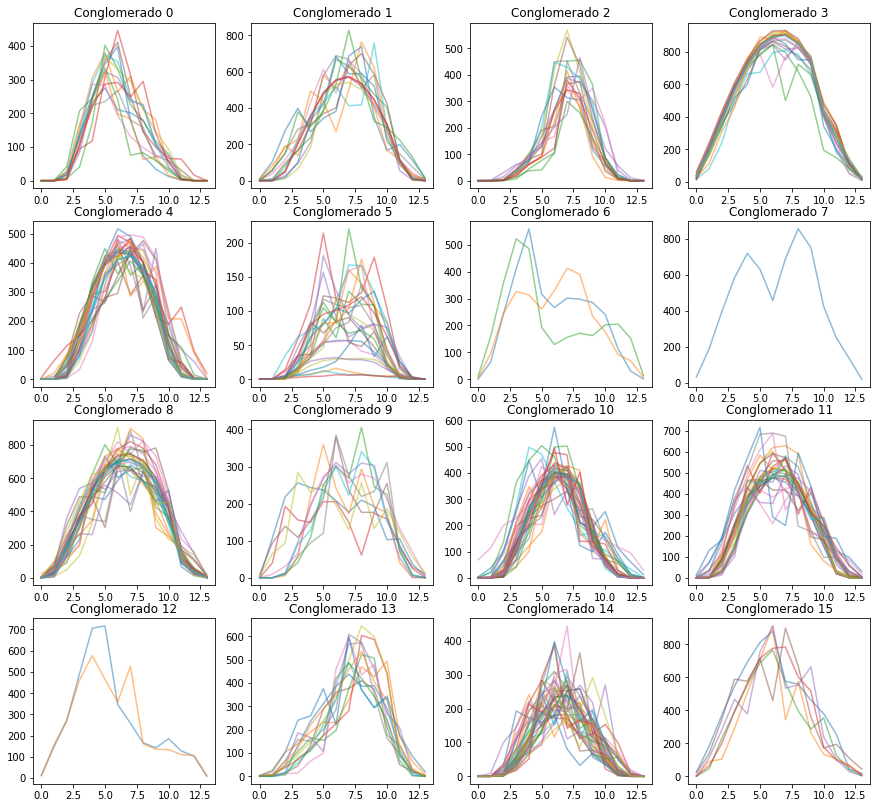

In [133]:
print('X_train (KNN)')
print_patrones(list_series=X_train,list_categorias=knn_pred_train,list_patrones=[],title_='Conglomerado ',namefile_='fig_t13_knn_train')

In [ ]:
print('X_test (KNN)')
print_patrones(list_series=X_test,list_categorias=knn_pred,list_patrones=[],title_='Conglomerado ',namefile_='fig_t13_knn_test')

In [ ]:
plt.figure(figsize=(20, 3))
plt.plot(x_total,alpha=1,color='blue')
plt.show()
plt.figure(figsize=(20, 3))
plt.plot(dx_total,alpha=1,color='red')
plt.show()
plt.figure(figsize=(20, 3))
plt.plot(ddx_total,alpha=1,color='green')
plt.show()
plt.figure(figsize=(20, 3))
sm.graphics.tsa.plot_acf(dx_total, lags=10)
plt.show()
plt.figure(figsize=(20, 3))
sm.graphics.tsa.plot_acf(ddx_total, lags=10)
plt.show()